In [1]:
from flow.controllers import SimCarFollowingController, GridRouter

from flow.core.params import SumoParams, EnvParams, InitialConfig, NetParams, \
    InFlows, SumoCarFollowingParams
from flow.core.params import VehicleParams
from flow.core.params import TrafficLightParams
from flow.core.params import SumoCarFollowingParams
from flow.core.params import InFlows

from flow.envs.traffic_light_grid import ADDITIONAL_ENV_PARAMS
from flow.envs import TrafficLightGridGenericObserver

from flow.networks import TrafficLightGridNetwork

from flow.core.experiment import Experiment

from signal_control.Testing.TrafficGrid_utils import *



import matplotlib.pyplot as plt
import numpy as np

In [2]:


v_enter = 10
inner_length = 300
long_length = 500
short_length = 500

# Defines rows and columns:
n_rows = 1
n_columns = 5


num_cars_left = 0
num_cars_right = 0
num_cars_top = 0
num_cars_bot = 0
tot_cars = (num_cars_left + num_cars_right) * n_columns \
           + (num_cars_top + num_cars_bot) * n_rows

grid_array = {
    "short_length": short_length,
    "inner_length": inner_length,
    "long_length": long_length,
    "row_num": n_rows,
    "col_num": n_columns,
    "cars_left": num_cars_left,
    "cars_right": num_cars_right,
    "cars_top": num_cars_top,
    "cars_bot": num_cars_bot
}


def gen_edges(col_num, row_num):
    """Generate the names of the outer edges in the grid network.

    Parameters
    ----------
    col_num : int
        number of columns in the grid
    row_num : int
        number of rows in the grid

    Returns
    -------
    list of str
        names of all the outer edges
    """
    edges = []

    # build the left and then the right edges
    for i in range(col_num):
        edges += ['left' + str(row_num) + '_' + str(i)]
        edges += ['right' + '0' + '_' + str(i)]

    # build the bottom and then top edges
    for i in range(row_num):
        edges += ['bot' + str(i) + '_' + '0']
        edges += ['top' + str(i) + '_' + str(col_num)]

    return edges


def get_flow_params(col_num, row_num, additional_net_params,main_flow,arterial_flow):
    """Define the network and initial params in the presence of inflows.

    Parameters
    ----------
    col_num : int
        number of columns in the grid
    row_num : int
        number of rows in the grid
    additional_net_params : dict
        network-specific parameters that are unique to the grid

    Returns
    -------
    flow.core.params.InitialConfig
        parameters specifying the initial configuration of vehicles in the
        network
    flow.core.params.NetParams
        network-specific parameters used to generate the network
    """
    initial = InitialConfig(
        spacing='custom', lanes_distribution=float('inf'), shuffle=True)

    inflow = InFlows()
    outer_edges = gen_edges(col_num, row_num)
    for i in range(len(outer_edges)):
        edge_id = outer_edges[i]
        if('top' in edge_id):
            inflow.add(
                veh_type='human',
                edge=edge_id,
                vehs_per_hour=main_flow,
                depart_lane='free',
                depart_speed=20)
        else:
            inflow.add(
                veh_type='human',
                edge=edge_id,
                vehs_per_hour=arterial_flow,
                depart_lane='free',
                depart_speed=20)

    net = NetParams(
        inflows=inflow,
        additional_params=additional_net_params)

    return initial, net


def get_non_flow_params(enter_speed, add_net_params):
    """Define the network and initial params in the absence of inflows.

    Note that when a vehicle leaves a network in this case, it is immediately
    returns to the start of the row/column it was traversing, and in the same
    direction as it was before.

    Parameters
    ----------
    enter_speed : float
        initial speed of vehicles as they enter the network.
    add_net_params: dict
        additional network-specific parameters (unique to the grid)

    Returns
    -------
    flow.core.params.InitialConfig
        parameters specifying the initial configuration of vehicles in the
        network
    flow.core.params.NetParams
        network-specific parameters used to generate the network
    """
    additional_init_params = {'enter_speed': enter_speed}
    initial = InitialConfig(
        spacing='custom', additional_params=additional_init_params)
    net = NetParams(additional_params=add_net_params)

    return initial, net


###### VEHICLES: ######

vehicles = VehicleParams()
vehicles.add(
    veh_id="human",
    routing_controller=(GridRouter, {}),
    car_following_params=SumoCarFollowingParams(
        min_gap=2.5,
        decel=7.5,  # avoid collisions at emergency stops
    ),
    num_vehicles=tot_cars)

additional_net_params = {
    "grid_array": grid_array,
    "speed_limit": 35,
    "horizontal_lanes": 1,
    "vertical_lanes": 1
}


###### FLOW RATES: ######


MAIN_FLOW = 1000
ARTERIAL_FLOW = 200


initial_config, net_params = get_flow_params(
    col_num=n_columns,
    row_num=n_rows,
    additional_net_params=additional_net_params,
    main_flow=MAIN_FLOW,
    arterial_flow=ARTERIAL_FLOW)

print('Defined simulation parameters.')

Defined simulation parameters.


In [3]:
additional_env_params = {
    'target_velocity': 50,
    'switch_time': 3.0,
    'num_observed': 2,
    'discrete': False,
    'tl_type': 'controlled',
    'observer': observer_ave_veh_speed_counts_tl_states
    }

print('Observation details defined.')

Observation details defined.


In [35]:
HORIZON = 100 # Number of simulation steps to be performed.

flow_params = dict(
    # name of the experiment
    exp_tag='traffic_light_grid',

    # name of the flow environment the experiment is running on
    env_name=TrafficLightGridGenericObserver,

    # name of the network class the experiment is running on
    network=TrafficLightGridNetwork,

    # simulator that is used by the experiment
    simulator='traci',

    # sumo-related parameters (see flow.core.params.SumoParams)
    sim=SumoParams(
        sim_step=0.5,
        render=True, # For no rendering set to False
    ),

    # environment related parameters (see flow.core.params.EnvParams)
    env=EnvParams(
        horizon=HORIZON,
        additional_params=additional_env_params,
    ),

    # network-related parameters (see flow.core.params.NetParams and the
    # network's documentation or ADDITIONAL_NET_PARAMS component). This is
    # filled in by the setup_exps method below.
    net=net_params,

    # vehicles to be placed in the network at the start of a rollout (see
    # flow.core.params.VehicleParams)
    veh=vehicles,

    # parameters specifying the positioning of vehicles upon initialization/
    # reset (see flow.core.params.InitialConfig). This is filled in by the
    # setup_exps method below.
    initial=initial_config,
)

print('Simulation parameters defined.')

Simulation parameters defined.


In [28]:
def static_controller(state):
    num_nodes = 5
    return np.zeros(num_nodes,)

def timer_switch_controller(state):
    num_nodes = 5
    
    actions = np.zeros(num_nodes,)
    
    time = state[-1]
    
    bc_light_state = state[2][0]
    
    if((time > 3.0) and (bc_light_state == 'rGrG')):
        actions[0] = 1
        print('Changing node 0')
    
    return actions

In [29]:
exp = Experiment(flow_params)

In [36]:
info_dict = exp.run(num_runs = 1, rl_actions = timer_switch_controller)

**********************************************************
**********************************************************
**********************************************************
significantly decrease after large number of rollouts. In 
order to avoid this, set SumoParams(restart_instance=True).
**********************************************************
**********************************************************
**********************************************************


AttributeError: 'Connection' object has no attribute '_socket'

In [31]:
states = info_dict['states']

all_counts,all_speeds,all_tl_states = get_ave_veh_speed_counts_tl_states_timeseries(states)

tl_states_numerical = numerical_tl_states(all_tl_states)

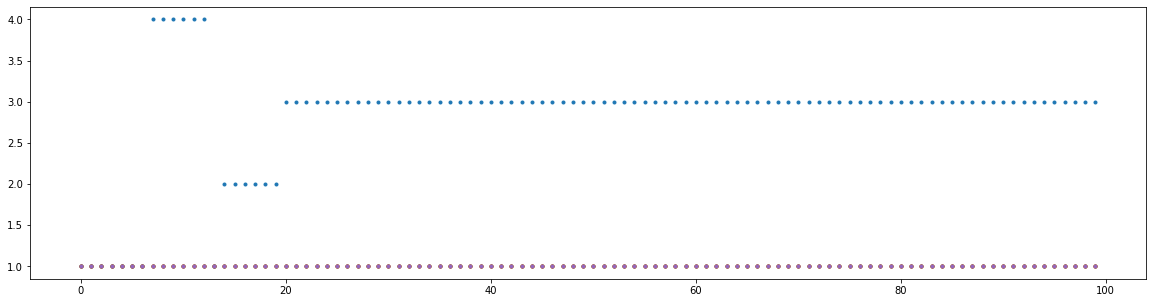

In [32]:

plt.figure(figsize=[20,5])
_ = plt.plot(tl_states_numerical,'.')

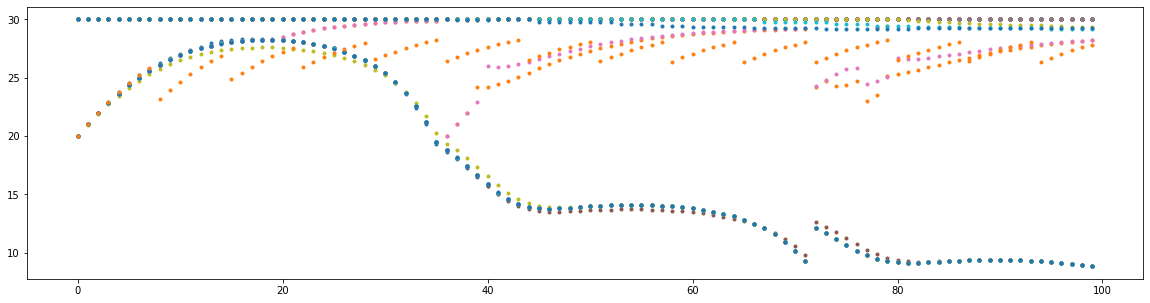

In [33]:
plt.figure(figsize=[20,5])
_ = plt.plot(all_speeds,'.')

In [ ]:
# info_dict = exp.run(num_runs = 1, rl_actions = static_controller)

# states = info_dict['states']

# all_counts,all_speeds,all_tl_states = get_ave_veh_speed_counts_tl_states_timeseries(states)

# tl_states_numerical = numerical_tl_states(all_tl_states)

# plt.figure(figsize=[20,5])
# _ = plt.plot(tl_states_numerical,'.')